# Quenching Times and Infall Times

This notebook uses the data generated by the timestep bulk processing (`h148bulk.py`, etc or `timescales_bulk.py`) to calculate infall times and quenching times for all the dwarfs that were at one time a satellite. It saves the resulting calculations to a data file, `QuenchingTimescales_200b.data` because it can take a while to generate the cumulative SFHs for all these galaxies.  

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import pynbody
pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

%matplotlib inline
print(mpl.get_backend())
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

module://ipykernel.pylab.backend_inline


## Define some functions

In [13]:
def read_file(path, halo_num):
    '''Function to read in the timestep bulk-processing datafile (from /home/akinhol/Data/Timescales/DataFiles/{name}.data)'''
    data = []
    with open(path,'rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    data = pd.DataFrame(data)
    
    if not halo_num=='all':
        data = data[data.z0haloid == halo_num]

    return data

def read_z0file(simname):
    ### leave this section as is
    data = []
    with open('/home/akinshol/Data/DataFiles/'+ simname + '.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

        data1 = pd.DataFrame(data)
        data1['sim'] = [simname]*len(data1)
        data1['g-r'] = 1.646*(data1['V_mag'] - data1['R_mag']) - 0.139
        return data1
    
def cumulative_sfh(simpath,halo_num):
    age = 13.800797497330507
    s = pynbody.load(simpath)
    s.physical_units()
    halo = s.halos()[halo_num]
    try:
        sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)
        plt.clf()
    except ValueError:
        print(f'Cannot create SFH, only {len(halo.s)} star particles')
        raise

    sfhmstar = np.sum(sfh)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    c_sfh = np.empty(shape=sfh.shape)
    for i in range(len(bincenters)):
        c_sfh[i] = np.sum(sfh[:i+1])/sfhmstar
    
    return c_sfh, age-bincenters

def specific_sfh(simpath,halo_num):
    age = 13.800797497330507
    s = pynbody.load(simpath)
    s.physical_units()
    halo = s.halos()[halo_num]
    try:
        sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)
        plt.clf()
    except ValueError:
        print(f'Cannot create SFH, only {len(halo.s)} star particles')
        raise

    sfhmstar = np.sum(sfh)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    c_sfh = np.empty(shape=sfh.shape)
    for i in range(len(bincenters)):
        c_sfh[i] = np.sum(sfh[:i+1])/sfhmstar
    
    return c_sfh, age-bincenters

[ 11.  31.  33.  40.  64. 103. 133. 137. 146. 185. 447.]
13.800797497330507 0.6424277573762747


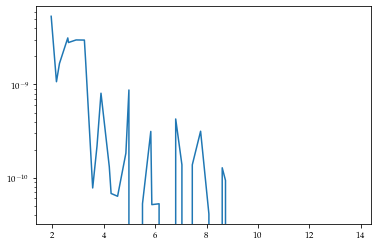

In [35]:
data = read_file('/home/akinshol/Data/Timescales/DataFiles20190731/h329.data','all')
print(np.unique(data.z0haloid))
data = data[data.z0haloid==33]
sSFR = data.sfr/data.mstar
time = data.time

plt.plot(time, sSFR)

# construct time bins:

    




plt.semilogy()
plt.show()

## Run through all halos and calculate quenching time, infall time, and gas loss times

this is the cell that uses our usual 99% threshold

In [9]:
h148 = '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.004096'
h242 = '/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.004096'
h229 = '/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h229.cosmo50PLK.3072gst5HbwK1BH.004096'
h329 = '/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h329.cosmo50PLK.3072gst5HbwK1BH.004096'

path = '/home/akinshol/Data/Timescales/DataFiles20190731/'

q_thresh = 0.99
q_lowerlim = 0.98
q_upperlim = 1.

# q_thresh = 0.90
# q_lowerlim = 0.85
# q_upperlim = 0.95

i_thresh = 1
i_upperlim = 0.9
i_lowerlim = 1.1

g_thresh = 0.1
g_lowerlim = 0.05
g_upperlim = 0.15


age = 13.800797497330507

with open('/home/akinshol/Data/Timescales/QuenchingTimescales_F19.data','wb') as f:
    for name,simpath in zip(['h148','h242','h229','h329'],[h148,h242,h229,h329]):
        data = read_file(path+name+'.data','all')
        
        ids = np.unique(np.array(data.z0haloid,dtype=int))
        
        for i in ids:
            print(f'Running for simulation {name}, halo {i}',end='\t')
            z0data = read_z0file(name)
            n_star = int(z0data[z0data.haloid==i].n_star)
            print(n_star)
            if n_star < 100:
                print('less than 100 star particles')
                continue
                
            current_data = read_file(path+name+'.data', i)
            time = np.array(current_data.time, dtype=float)
            mstar = np.array(current_data.mstar, dtype=float)[0]
            
            sSFR = np.array(current_data['sfr'][time > 13.6])[0] / mstar
            HIratio = np.array(current_data['mHI'][time > 13.6])[0] / mstar
            print(f'sSFR {sSFR}, HI richness {HIratio}')
            
            time = age - time
            
            if sSFR > 1e-11:
                is_quenched = False
            else:
                is_quenched = True
#                 print('Halo unquenched, skipping...')
#                 continue           
            
            # skip if we don't have at least 10 Gyr of data from merger trees
            if np.max(time) < 10:
                print(f'data only goes back {np.max(time):.2f} Gyr, skipping')
                continue
                
            c_sfh, bc = cumulative_sfh(simpath,i)

            dist = np.array(current_data.h1dist, dtype=float)
            gasfrac = np.array(current_data.gasfrac, dtype=float)
            HIratio = np.array(current_data.mHI,dtype=float)/np.array(current_data.mstar, dtype=float)
            mvir = np.array(current_data.mass, dtype=float)[0]
            peak_Pram = np.max(np.array(current_data.Pram, dtype=float))
            peak_Pratio = np.max(np.array(current_data.ratio, dtype=float))
            
            
            Mr = float(z0data[z0data.haloid==i].R_mag.tolist()[0])
            print(Mr)
            
            if gasfrac[0] > 0:
                has_gas = True
            else:
                has_gas = False

            # get quenched time
            try:
                tq = np.max(bc[c_sfh >= q_thresh])
                tq_lowerlim = np.max(bc[c_sfh >= q_lowerlim])
                tq_upperlim = np.max(bc[c_sfh >= q_upperlim])
                t90 = np.max(bc[c_sfh >= 0.9])
            except:
                print('Skipping quenching time (check this!)')
                continue

            # get gas loss time
            if not has_gas:
                try:
                    tg = np.max(time[gasfrac < g_thresh])
                    tg_lowerlim = np.max(time[gasfrac < g_lowerlim])
                    tg_upperlim = np.max(time[gasfrac < g_upperlim])
                except ValueError:
                    tg = None
                    tg_lowerlim = None
                    tg_upperlim = None
            else:
                tg = 0
                tg_lowerlim = 0
                tg_upperlim = 0
                print('Has gas at z=0, setting tgas = 0')
                
            # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 0.5:
                    th = t
                    print('Hi gas loss time %.2f' % th)
                    break
                else:
                    th = None
                    
            # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 1:
                    th_lowerlim = t
                    break
                else:
                    th_lowerlim = None
            
                        # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 0.2:
                    th_upperlim = t
                    break
                else:
                    th_upperlim = None

            # remove gas loss / HI gas loss time if there was never any gas
            if (gasfrac == 0.).all():
                tg = None
                th = None

            # get infall time
            try:
                ti = np.max(time[dist <= i_thresh])
                ti_upperlim = np.max(time[dist <= i_upperlim])
                ti_lowerlim = np.max(time[dist <= i_lowerlim])
            except ValueError:
                ti, ti_upperlim, ti_lowerlim = None, None, None

            
            # calculate periapsis and apoapsis
            periapsis = np.min(dist)
            if ti is not None:
                try:
                    dist_after_infall = dist[time < ti-1] # distance values 
                    time_after_infall = time[time < ti-1]

                    apoapsis = np.max(dist_after_infall)
                    apocenter = np.argmax(dist_after_infall)


                    if time_after_infall[apocenter] == np.max(time_after_infall):
                        print('Apoapsis occurs at infall, assuming inaccuracy')
                        apoapsis = None

                    if time_after_infall[apocenter] == np.min(time_after_infall):
                        print('Apoapsis occurs at z = 0, assuming inaccuracy')
                        apoapsis = None

                    if apoapsis is not None:
                        eccentricity = (apoapsis - periapsis) / (apoapsis + periapsis)
                        print(f'eccentricity {eccentricity}')
                    else:
                        eccentricity = None
                except:
                    print('Uncaught error in eccentricity calculation')
                    apoapsis, eccentricity = None, None
            else:
                apoapsis, periapsis, eccentricity = None, None, None


            print(f'tquench = {tq}, tinfall = {ti}')

            
            pickle.dump({
                'haloid':i,
                'quenched':is_quenched,
                'has_gas':has_gas,
                'tquench':tq,
                'tquench_lower':tq_lowerlim,
                'tquench_upper':tq_upperlim,
                't90': t90,
                'tinfall':ti,
                'tinfall_lower':ti_lowerlim,
                'tinfall_upper':ti_upperlim,
                'tHI':th,
                'tHI_lower':th_lowerlim,
                'tHI_upper':th_upperlim,
                'tgasloss':tg,
                'tgasloss_lower':tg_lowerlim,
                'tgasloss_upper':tg_upperlim,
                'M_star': mstar,
                'n_star': n_star,
                'mass': mvir,
                'R_mag':Mr,
                'peak_Pram':peak_Pram, 
                'peak_Pratio':peak_Pratio,
                'periapsis':periapsis,
                'apoapsis':apoapsis,
                'eccentricity':eccentricity,
                'sim':name                
            }, f, protocol=2)
            

Running for simulation h148, halo 2	435389
sSFR 2.09932756048495e-10, HI richness 1.4090900689907306
-19.151902136759315
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
Apoapsis occurs at infall, assuming inaccuracy
tquench = 0.05299582894024368, tinfall = 1.7239215218961164
Running for simulation h148, halo 3	295443
sSFR 6.56773342303376e-11, HI richness 0.6894714614330032
-18.1838678540327
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
eccentricity 0.12647767635199247
tquench = 0.1595931059946576, tinfall = 4.309803804384165
Running for simulation h148, halo 5	85749
sSFR 5.960126773487672e-11, HI richness 0.8336604329432376


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide


-16.934670205267185
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
Apoapsis occurs at z = 0, assuming inaccuracy
tquench = 0.1569100074026899, tinfall = 2.5858822827275567
Running for simulation h148, halo 6	65528
sSFR 1.1276344572871382e-10, HI richness 1.0868156722577273
-16.800933655105432
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
Apoapsis occurs at z = 0, assuming inaccuracy
tquench = 0.053058303071122026, tinfall = 2.5858822827275567
Running for simulation h148, halo 9	47542
sSFR 1.0457537366433392e-11, HI richness 0.14671756231366834
-15.972780397840097
Has gas at z=0, setting tgas = 0
Hi gas loss time 10.77
eccentricity 0.3801067127954853
tquench = 0.8928065760237747, tinfall = 4.740784184796915
Running for simulation h148, halo 10	4919
sSFR 2.5541809791093712e-11, HI richness 0.8441868866656347
-14.024399970293759
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
tquench = 0.36015566867288484, tinfall = None
Running for simulation h148, halo 11	26093
s

<Figure size 432x288 with 0 Axes>

## Run through all halos and calculate quenching time and infall time

this is the cell that uses a new sSFR $< 1\times10^{-11}$ threshold

In [9]:
h148 = '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.004096'
h242 = '/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.004096'
h229 = '/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h229.cosmo50PLK.3072gst5HbwK1BH.004096'
h329 = '/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h329.cosmo50PLK.3072gst5HbwK1BH.004096'

path = '/home/akinshol/Data/Timescales/DataFiles20190731/'

q_thresh = 1e-11
# q_lowerlim = 
# q_upperlim = 

# q_thresh = 0.90
# q_lowerlim = 0.85
# q_upperlim = 0.95

i_thresh = 1
i_upperlim = 0.9
i_lowerlim = 1.1

g_thresh = 0.1
g_lowerlim = 0.05
g_upperlim = 0.15


age = 13.800797497330507

with open('/home/akinshol/Data/Timescales/QuenchingTimescales_F19.data','wb') as f:
    for name,simpath in zip(['h148','h242','h229','h329'],[h148,h242,h229,h329]):
        data = read_file(path+name+'.data','all')
        
        ids = np.unique(np.array(data.z0haloid,dtype=int))
        
        for i in ids:
            print(f'Running for simulation {name}, halo {i}',end='\t')
            z0data = read_z0file(name)
            n_star = int(z0data[z0data.haloid==i].n_star)
            
            print(n_star)
            if n_star < 100:
                print('less than 100 star particles')
                continue
                
            current_data = read_file(path+name+'.data', i)
            time = np.array(current_data.time, dtype=float)
            mstar = np.array(current_data.mstar, dtype=float)[0]
            
            sSFR = np.array(current_data['sfr'][time > 13.6])[0] / mstar
            HIratio = np.array(current_data['mHI'][time > 13.6])[0] / mstar
            print(f'sSFR {sSFR}, HI richness {HIratio}')
            
            time = age - time
            
            if sSFR > 1e-11:
                is_quenched = False
            else:
                is_quenched = True
#                 print('Halo unquenched, skipping...')
#                 continue           
            
            # skip if we don't have at least 10 Gyr of data from merger trees
            if np.max(time) < 10:
                print(f'data only goes back {np.max(time):.2f} Gyr, skipping')
                continue
                
            c_sfh, bc = cumulative_sfh(simpath,i)

            dist = np.array(current_data.h1dist, dtype=float)
            gasfrac = np.array(current_data.gasfrac, dtype=float)
            HIratio = np.array(current_data.mHI,dtype=float)/np.array(current_data.mstar, dtype=float)
            mvir = np.array(current_data.mass, dtype=float)[0]
            peak_Pram = np.max(np.array(current_data.Pram, dtype=float))
            peak_Pratio = np.max(np.array(current_data.ratio, dtype=float))
            
            
            Mr = float(z0data[z0data.haloid==i].R_mag.tolist()[0])
            print(Mr)
            
            if gasfrac[0] > 0:
                has_gas = True
            else:
                has_gas = False

            # get quenched time
            try:
                tq = np.max(bc[c_sfh >= q_thresh])
                tq_lowerlim = np.max(bc[c_sfh >= q_lowerlim])
                tq_upperlim = np.max(bc[c_sfh >= q_upperlim])
                t90 = np.max(bc[c_sfh >= 0.9])
            except:
                print('Skipping quenching time (check this!)')
                continue

            # get gas loss time
            if not has_gas:
                try:
                    tg = np.max(time[gasfrac < g_thresh])
                    tg_lowerlim = np.max(time[gasfrac < g_lowerlim])
                    tg_upperlim = np.max(time[gasfrac < g_upperlim])
                except ValueError:
                    tg = None
                    tg_lowerlim = None
                    tg_upperlim = None
            else:
                tg = 0
                tg_lowerlim = 0
                tg_upperlim = 0
                print('Has gas at z=0, setting tgas = 0')
                
            # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 0.5:
                    th = t
                    print('Hi gas loss time %.2f' % th)
                    break
                else:
                    th = None
                    
            # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 1:
                    th_lowerlim = t
                    break
                else:
                    th_lowerlim = None
            
                        # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 0.2:
                    th_upperlim = t
                    break
                else:
                    th_upperlim = None

            # remove gas loss / HI gas loss time if there was never any gas
            if (gasfrac == 0.).all():
                tg = None
                th = None

            # get infall time
            try:
                ti = np.max(time[dist <= i_thresh])
                ti_upperlim = np.max(time[dist <= i_upperlim])
                ti_lowerlim = np.max(time[dist <= i_lowerlim])
            except ValueError:
                ti, ti_upperlim, ti_lowerlim = None, None, None

            
            # calculate periapsis and apoapsis
            periapsis = np.min(dist)
            if ti is not None:
                try:
                    dist_after_infall = dist[time < ti-1] # distance values 
                    time_after_infall = time[time < ti-1]

                    apoapsis = np.max(dist_after_infall)
                    apocenter = np.argmax(dist_after_infall)


                    if time_after_infall[apocenter] == np.max(time_after_infall):
                        print('Apoapsis occurs at infall, assuming inaccuracy')
                        apoapsis = None

                    if time_after_infall[apocenter] == np.min(time_after_infall):
                        print('Apoapsis occurs at z = 0, assuming inaccuracy')
                        apoapsis = None

                    if apoapsis is not None:
                        eccentricity = (apoapsis - periapsis) / (apoapsis + periapsis)
                        print(f'eccentricity {eccentricity}')
                    else:
                        eccentricity = None
                except:
                    print('Uncaught error in eccentricity calculation')
                    apoapsis, eccentricity = None, None
            else:
                apoapsis, periapsis, eccentricity = None, None, None


            print(f'tquench = {tq}, tinfall = {ti}')

            
            pickle.dump({
                'haloid':i,
                'quenched':is_quenched,
                'has_gas':has_gas,
                'tquench':tq,
                'tquench_lower':tq_lowerlim,
                'tquench_upper':tq_upperlim,
                't90': t90,
                'tinfall':ti,
                'tinfall_lower':ti_lowerlim,
                'tinfall_upper':ti_upperlim,
                'tHI':th,
                'tHI_lower':th_lowerlim,
                'tHI_upper':th_upperlim,
                'tgasloss':tg,
                'tgasloss_lower':tg_lowerlim,
                'tgasloss_upper':tg_upperlim,
                'M_star': mstar,
                'n_star': n_star,
                'mass': mvir,
                'R_mag':Mr,
                'peak_Pram':peak_Pram, 
                'peak_Pratio':peak_Pratio,
                'periapsis':periapsis,
                'apoapsis':apoapsis,
                'eccentricity':eccentricity,
                'sim':name                
            }, f, protocol=2)
            

Running for simulation h148, halo 2	435389
sSFR 2.09932756048495e-10, HI richness 1.4090900689907306
-19.151902136759315
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
Apoapsis occurs at infall, assuming inaccuracy
tquench = 0.05299582894024368, tinfall = 1.7239215218961164
Running for simulation h148, halo 3	295443
sSFR 6.56773342303376e-11, HI richness 0.6894714614330032
-18.1838678540327
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
eccentricity 0.12647767635199247
tquench = 0.1595931059946576, tinfall = 4.309803804384165
Running for simulation h148, halo 5	85749
sSFR 5.960126773487672e-11, HI richness 0.8336604329432376


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide


-16.934670205267185
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
Apoapsis occurs at z = 0, assuming inaccuracy
tquench = 0.1569100074026899, tinfall = 2.5858822827275567
Running for simulation h148, halo 6	65528
sSFR 1.1276344572871382e-10, HI richness 1.0868156722577273
-16.800933655105432
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
Apoapsis occurs at z = 0, assuming inaccuracy
tquench = 0.053058303071122026, tinfall = 2.5858822827275567
Running for simulation h148, halo 9	47542
sSFR 1.0457537366433392e-11, HI richness 0.14671756231366834
-15.972780397840097
Has gas at z=0, setting tgas = 0
Hi gas loss time 10.77
eccentricity 0.3801067127954853
tquench = 0.8928065760237747, tinfall = 4.740784184796915
Running for simulation h148, halo 10	4919
sSFR 2.5541809791093712e-11, HI richness 0.8441868866656347
-14.024399970293759
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
tquench = 0.36015566867288484, tinfall = None
Running for simulation h148, halo 11	26093
s

<Figure size 432x288 with 0 Axes>

## Function to read in the data file

In [36]:
def read_data():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_F19.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

# Quenching Timescale vs. Stellar Mass

Small version, for a 1-column width figure.

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


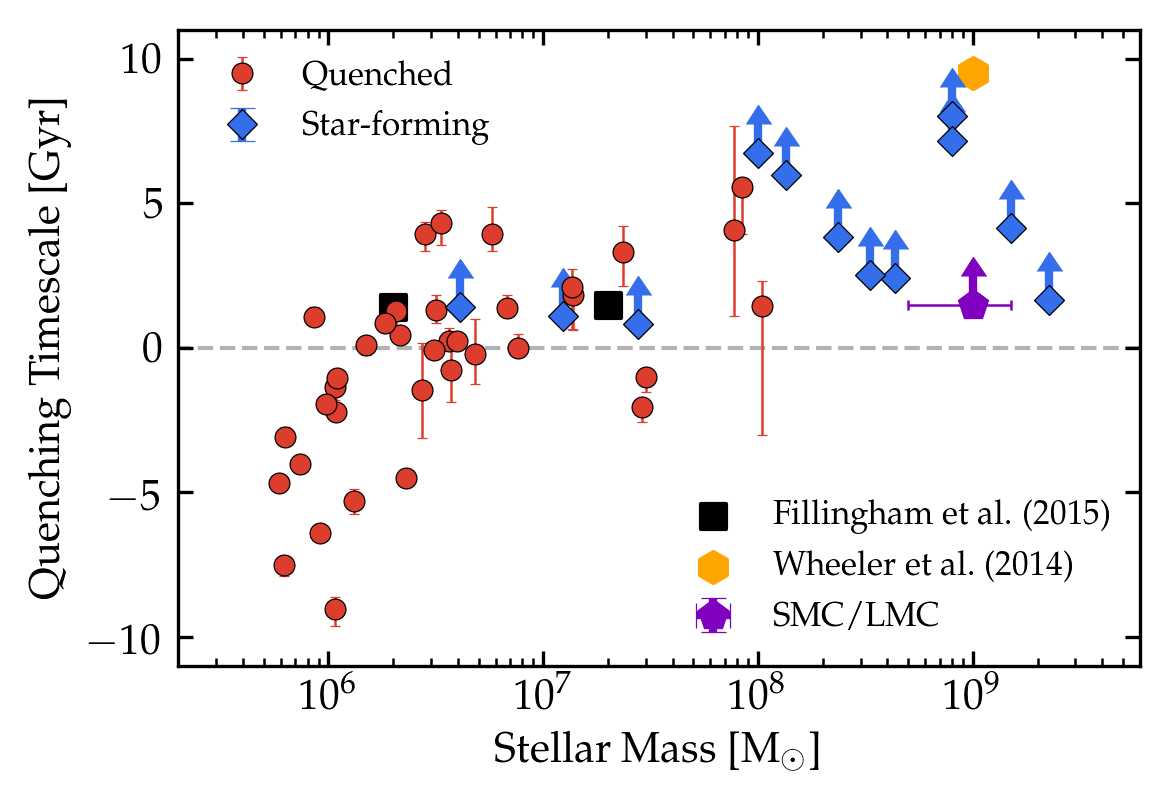

In [50]:
data = read_data()
tinfall = np.array(data.tinfall, dtype=float)
tinfall_upper_error = np.abs(np.array(data.tinfall_upper, dtype=float) - tinfall)
tinfall_lower_error = np.abs(np.array(data.tinfall_lower, dtype=float) - tinfall)

tquench = np.array(data.tquench, dtype=float)
tquench_upper_error = np.abs(np.array(data.tquench_lower, dtype=float) - tquench) # flipped intentionally
tquench_lower_error = np.abs(np.array(data.tquench_upper, dtype=float) - tquench)

tau_upper_err = np.sqrt(tquench_upper_error**2 + tinfall_upper_error**2)
tau_lower_err = np.sqrt(tquench_lower_error**2 + tinfall_lower_error**2)

fig, ax = plt.subplots(1,1,figsize=(4,2.8),dpi=300)
q = np.array(data.quenched,dtype=bool)
r = np.array((tinfall-tquench) < -2, dtype=bool) & np.array(data.tquench > 9, dtype=bool)

p1 = ax.errorbar(data.M_star[q ],tinfall[q] - tquench[q],
            yerr = np.array([tau_lower_err[q], tau_upper_err[q]]),
            elinewidth=0.6,
            mec = 'k', 
            mew = 0.3,
            ecolor='#DD3D2D',
            capsize=1.2,
            capthick=0.6,
            fmt='o', 
            color = '#DD3D2D',
            ms = 5,
            zorder=1)#, label='Quenched')



p3 = ax.errorbar(data.M_star[~q], tinfall[~q] - tquench[~q],
            yerr = [1]*len(tinfall[~q]),
            elinewidth=2,
            mec = 'k', 
            mew = 0.3,
            ecolor='#346eeb',
            capsize=3,
            capthick=2,
            fmt='D',
            color = '#346eeb',
            ms = 5,
            lolims=True,
            zorder=1)#, label='Star-forming')



# zero line
ax.plot([1e2, 1e10], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)


# add observational data from Fillingham et al (2015)
x = np.array([2e6, 2e7])
y = np.array([1.4, 1.5])
e1 = ax.scatter(x, y, marker='s', color='k')#, label='Fillingham+15')

# add observational data from Wheeler et al (2014)
x = np.array([1e9])
y = np.array([9.5])
e2 = ax.scatter(x, y, marker = 'h', color='orange', s=55)#, label='Wheeler+14')


# add SMC/LMC data from Kallivayalil
x = np.array([1e9])
y = np.array([1.5])
e3 = ax.errorbar(x, y, xerr = 0.001, yerr=1, 
            elinewidth=2,
            mec = '#8000bf', 
            mew = 0.3,
            ecolor='#8000bf',
            capsize=3,
            capthick=2,
            fmt='p',
            color = '#8000bf',
            ms = 7.5,
            lolims=True,
            zorder=1)#, label='SMC/LMC')

ax.errorbar(x, y,  xerr=5e8, marker = 'p', ms=0,
            ecolor='#8000bf',
            elinewidth=0.6,
            capsize=1.2,
            capthick=0.6,
            fmt='o')

leg1 = ax.legend([e1,e2,e3],['Fillingham et al. (2015)','Wheeler et al. (2014)','SMC/LMC'], loc='lower right', frameon=False, prop={'size':8})
leg2 = ax.legend([p1,p3],['Quenched', 'Star-forming'], loc='upper left', frameon=False, prop={'size':8})
ax.add_artist(leg1)

ax.set_xlim(2e5,6e9)
ax.set_ylim(-11, 11)
# ax.set_ylim(-14,3)

ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Quenching Timescale [Gyr]')
# ax.legend(frameon=False, prop={'size':8}, loc='upper left')
ax.semilogx()

ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig('plots/tq_mass_F19.png', dpi=300)

plt.show()

# Quenching Timescale vs. Stellar Mass

here i have made a larger version, in case we want to make this the full-width plot and draw extra emphasis to it, which i think may be a good idea since it really emphasizes the mass scales. 

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


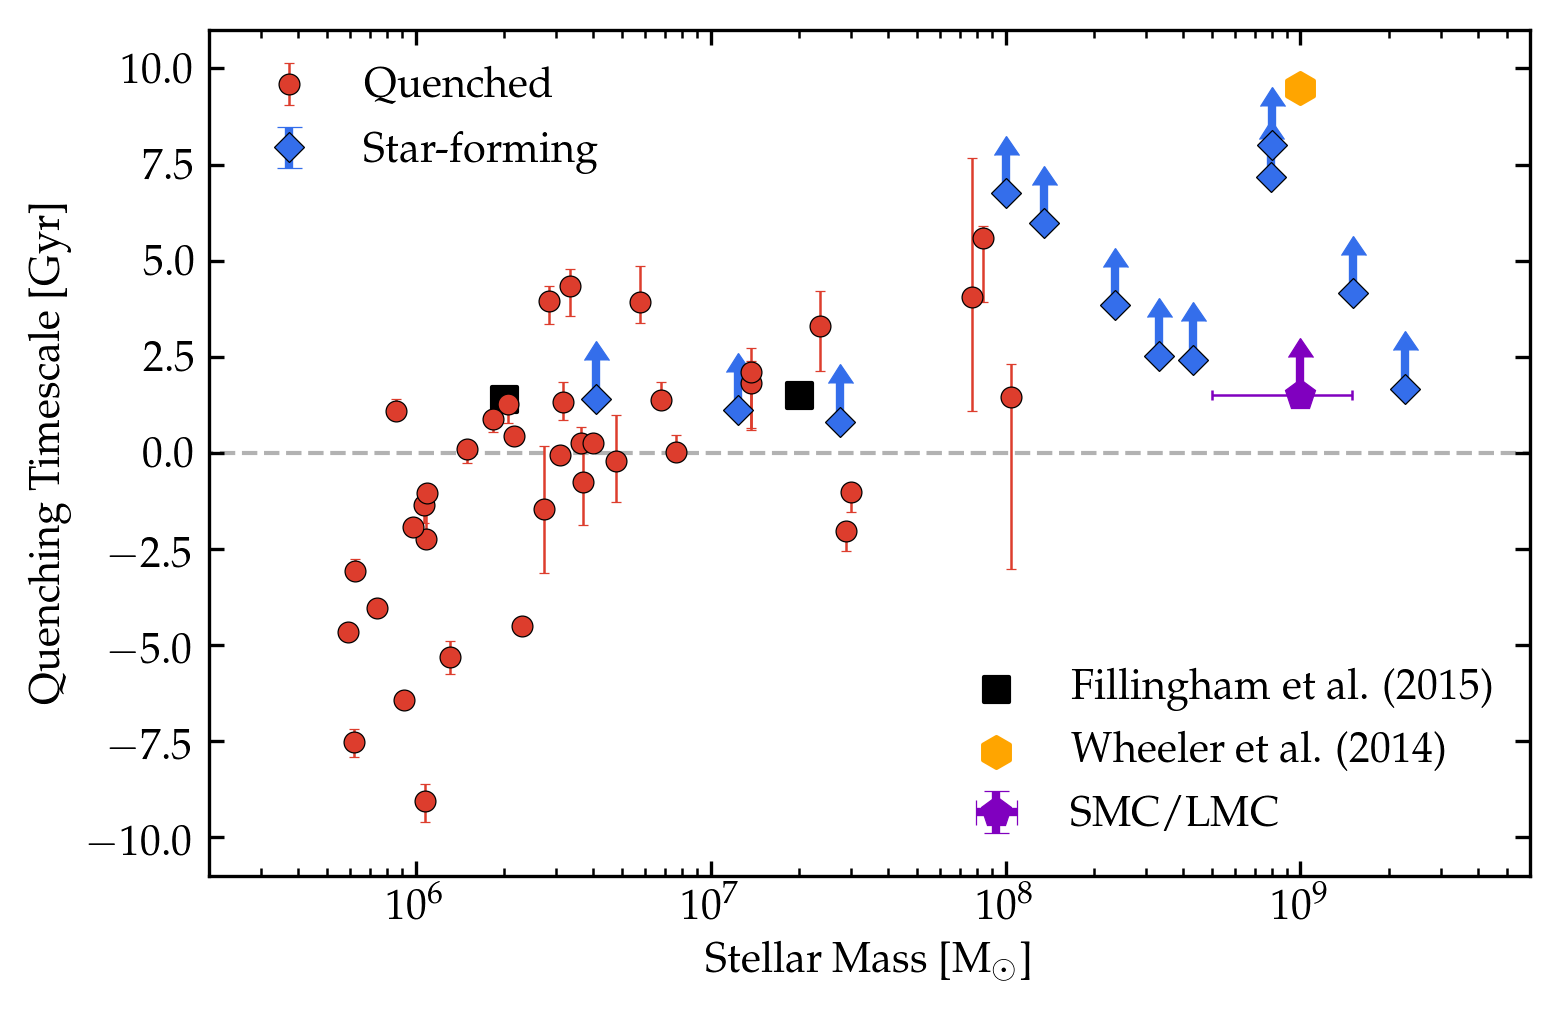

In [49]:
data = read_data()
tinfall = np.array(data.tinfall, dtype=float)
tinfall_upper_error = np.abs(np.array(data.tinfall_upper, dtype=float) - tinfall)
tinfall_lower_error = np.abs(np.array(data.tinfall_lower, dtype=float) - tinfall)

tquench = np.array(data.tquench, dtype=float)
tquench_upper_error = np.abs(np.array(data.tquench_lower, dtype=float) - tquench) # flipped intentionally
tquench_lower_error = np.abs(np.array(data.tquench_upper, dtype=float) - tquench)

tau_upper_err = np.sqrt(tquench_upper_error**2 + tinfall_upper_error**2)
tau_lower_err = np.sqrt(tquench_lower_error**2 + tinfall_lower_error**2)

fig, ax = plt.subplots(1,1,figsize=(5.3,3.5),dpi=300)
q = np.array(data.quenched,dtype=bool)
r = np.array((tinfall-tquench) < -2, dtype=bool) & np.array(data.tquench > 9, dtype=bool)

p1 = ax.errorbar(data.M_star[q ],tinfall[q] - tquench[q],
            yerr = np.array([tau_lower_err[q], tau_upper_err[q]]),
            elinewidth=0.6,
            mec = 'k', 
            mew = 0.3,
            ecolor='#DD3D2D',
            capsize=1.2,
            capthick=0.6,
            fmt='o', 
            color = '#DD3D2D',
            ms = 5,
            zorder=1)#, label='Quenched')



p3 = ax.errorbar(data.M_star[~q], tinfall[~q] - tquench[~q],
            yerr = [1]*len(tinfall[~q]),
            elinewidth=2,
            mec = 'k', 
            mew = 0.3,
            ecolor='#346eeb',
            capsize=3,
            capthick=2,
            fmt='D',
            color = '#346eeb',
            ms = 5,
            lolims=True,
            zorder=1)#, label='Star-forming')



# zero line
ax.plot([1e2, 1e10], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)


# add observational data from Fillingham et al (2015)
x = np.array([2e6, 2e7])
y = np.array([1.4, 1.5])
e1 = ax.scatter(x, y, marker='s', color='k')#, label='Fillingham+15')

# add observational data from Wheeler et al (2014)
x = np.array([1e9])
y = np.array([9.5])
e2 = ax.scatter(x, y, marker = 'h', color='orange', s=55)#, label='Wheeler+14')


# add SMC/LMC data from Kallivayalil
x = np.array([1e9])
y = np.array([1.5])
e3 = ax.errorbar(x, y, xerr = 0.001, yerr=1, 
            elinewidth=2,
            mec = '#8000bf', 
            mew = 0.3,
            ecolor='#8000bf',
            capsize=3,
            capthick=2,
            fmt='p',
            color = '#8000bf',
            ms = 7.5,
            lolims=True,
            zorder=1)#, label='SMC/LMC')

ax.errorbar(x, y,  xerr=5e8, marker = 'p', ms=0,
            ecolor='#8000bf',
            elinewidth=0.6,
            capsize=1.2,
            capthick=0.6,
            fmt='o')

leg1 = ax.legend([e1,e2,e3],['Fillingham et al. (2015)','Wheeler et al. (2014)','SMC/LMC'], loc='lower right', frameon=False)
leg2 = ax.legend([p1,p3],['Quenched', 'Star-forming'], loc='upper left', frameon=False)
ax.add_artist(leg1)

ax.set_xlim(2e5,6e9)
ax.set_ylim(-11, 11)
# ax.set_ylim(-14,3)

ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Quenching Timescale [Gyr]')
# ax.legend(frameon=False, prop={'size':8}, loc='upper left')
ax.semilogx()

ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig('plots/tq_mass_F19_large.png', dpi=300)

plt.show()

# Quenching Time vs Infall Time

Here I have modified the plot that went in my MAP paper by removing those halos w < 100 star particles and moving the reionization line. This makes this plot look pretty empty, so I will try a few things to make it look better.

This plot is the big version (if we still wanted it to be a full-width figure). 

Loading...	loaded data


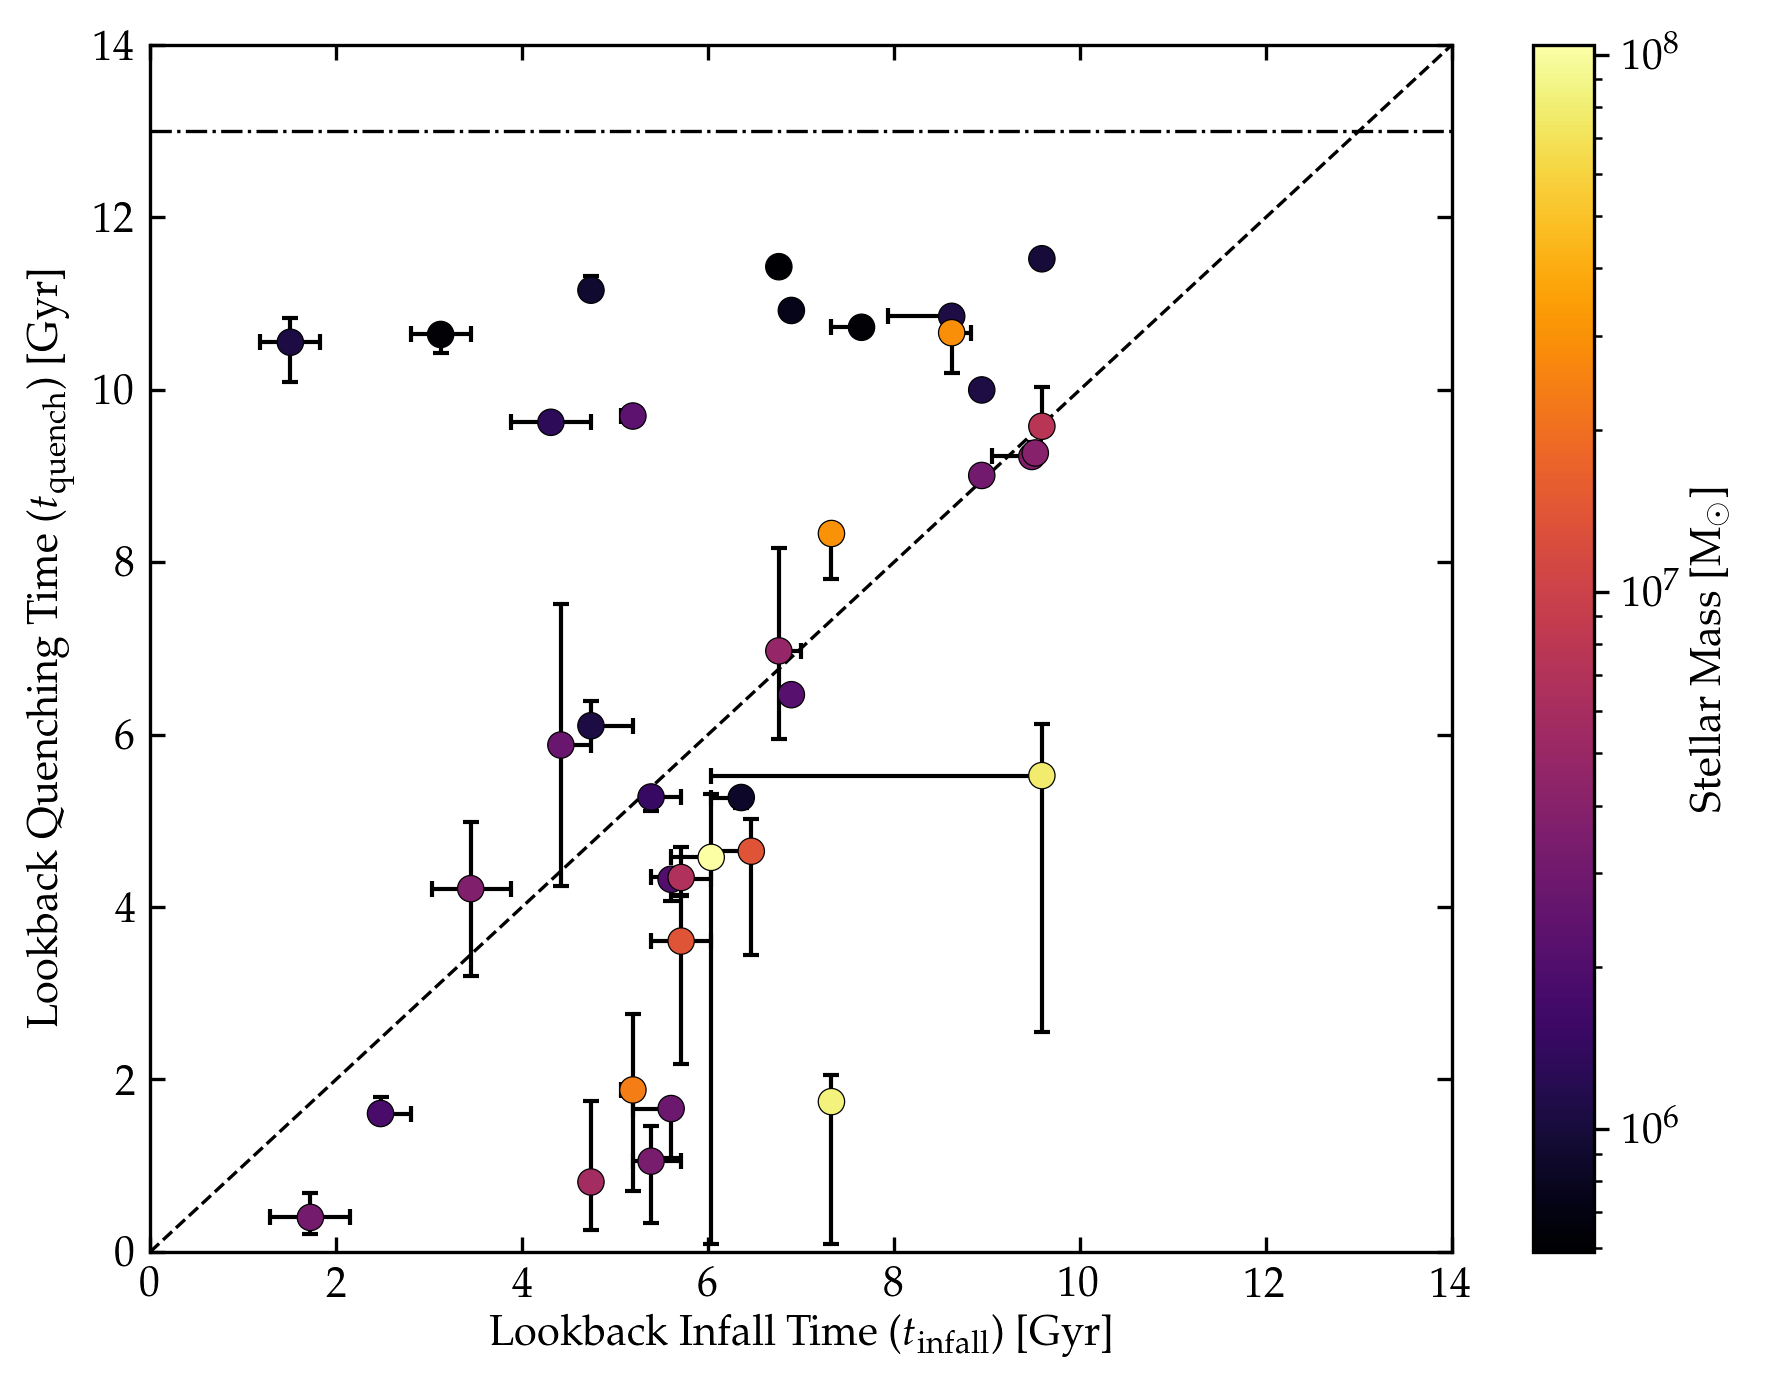

In [43]:
 
reiontime = 13 # in our cosmic UV model reionization occurs at z ~ 6.7 or 13 Gyr ago


fig, ax = plt.subplots(1,1,figsize=(7,5.33),dpi=300)

print('Loading...', end='\t')
data = read_data()

data = data[(~np.isnan(np.array(data.tinfall,dtype=float)))&(np.array(data.quenched,dtype=bool))]
data = data[~((data.sim=='h148')&(data.haloid==759))]


tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)
tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)

tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')


ax.errorbar(tinfall, tquench,
             xerr = np.array([np.abs(tinfall-tinfall_upper), np.abs(tinfall-tinfall_lower)]),
             yerr = np.array([np.abs(tquench-tquench_upper), np.abs(tquench-tquench_lower)]),
             fmt = 'o',
             elinewidth=1,
             ecolor='k',
             capsize=2,
             capthick=1,
             mfc = 'none',
             mec = 'none',
             ms = 0,
             zorder = 10)

im = ax.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 zorder = 11)

# plot diagonal line
ax.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax.set_xlim(0,14)
ax.set_ylim(0,14)

# for i, (haloid, simulation) in enumerate(zip(newids, sim)):
#     if tinfall[i] != None and tquench[i] != None:
#         ax.annotate(str(simulation)+'-'+str(int(haloid)), (tinfall[i]+0.2, tquench[i]+0.2), size=5)


cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')


ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.savefig('plots/tq_ti_F19.png', dpi=300)
plt.show()

# Quenching time vs. Infall time

a smaller version, to put as a 1-column wide figure

Loading...	loaded data


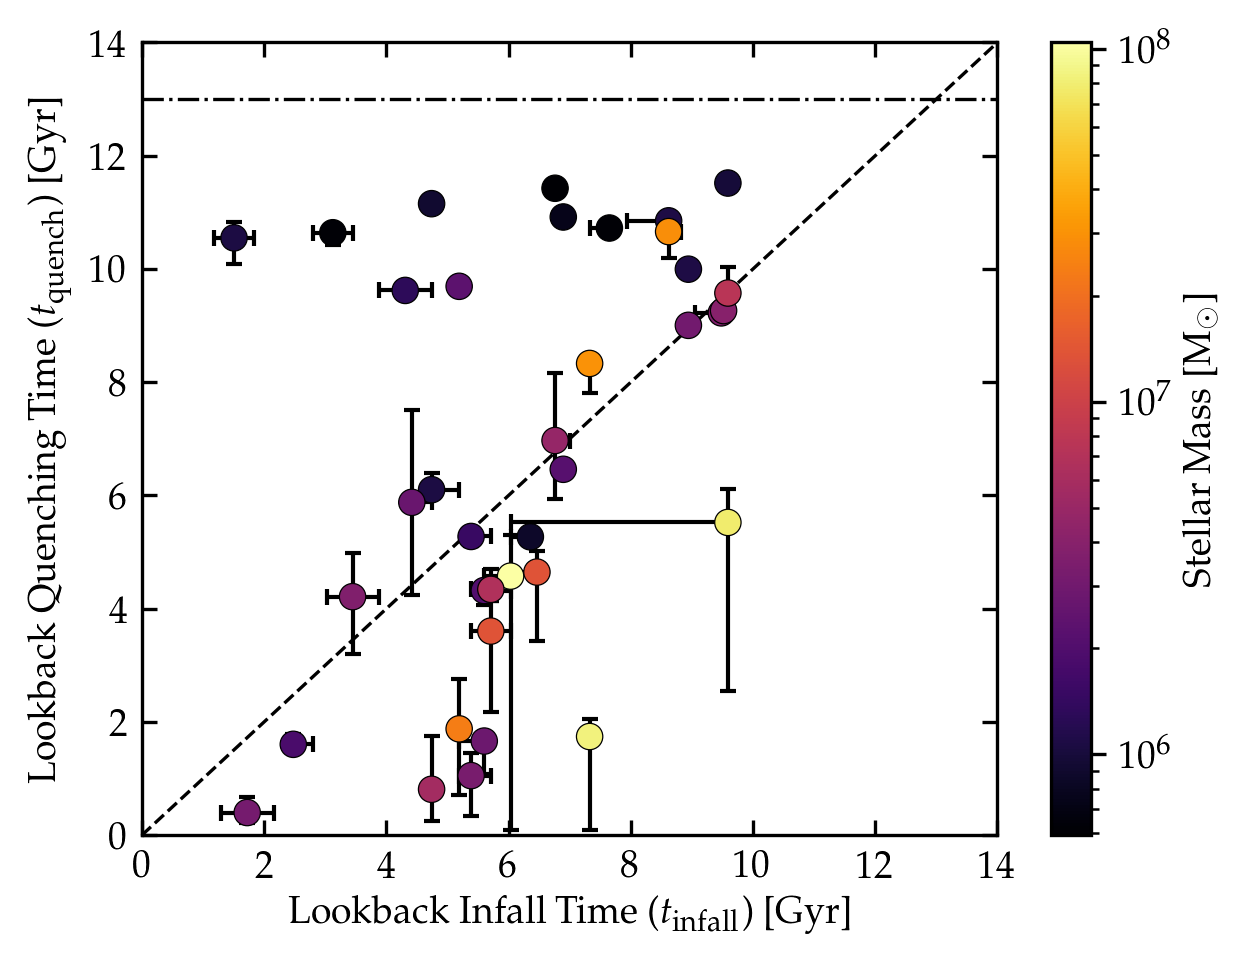

In [56]:
 
reiontime = 13 # in our cosmic UV model reionization occurs at z ~ 6.7 or 13 Gyr ago


fig, ax = plt.subplots(1,1,figsize=(4.6,3.5),dpi=300)

print('Loading...', end='\t')
data = read_data()

data = data[(~np.isnan(np.array(data.tinfall,dtype=float)))&(np.array(data.quenched,dtype=bool))]
data = data[~((data.sim=='h148')&(data.haloid==759))]


tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)
tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)

tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')


ax.errorbar(tinfall, tquench,
             xerr = np.array([np.abs(tinfall-tinfall_upper), np.abs(tinfall-tinfall_lower)]),
             yerr = np.array([np.abs(tquench-tquench_upper), np.abs(tquench-tquench_lower)]),
             fmt = 'o',
             elinewidth=1,
             ecolor='k',
             capsize=2,
             capthick=1,
             mfc = 'none',
             mec = 'none',
             ms = 0,
             zorder = 10)

im = ax.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 zorder = 11)

# plot diagonal line
ax.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax.set_xlim(0,14)
ax.set_ylim(0,14)

cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')


ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.savefig('plots/tq_ti_F19_small.png', dpi=300)
plt.show()

# Quenching time vs. Infall time

With stellar masses estimated from $M_R$. 

Loading...	loaded data


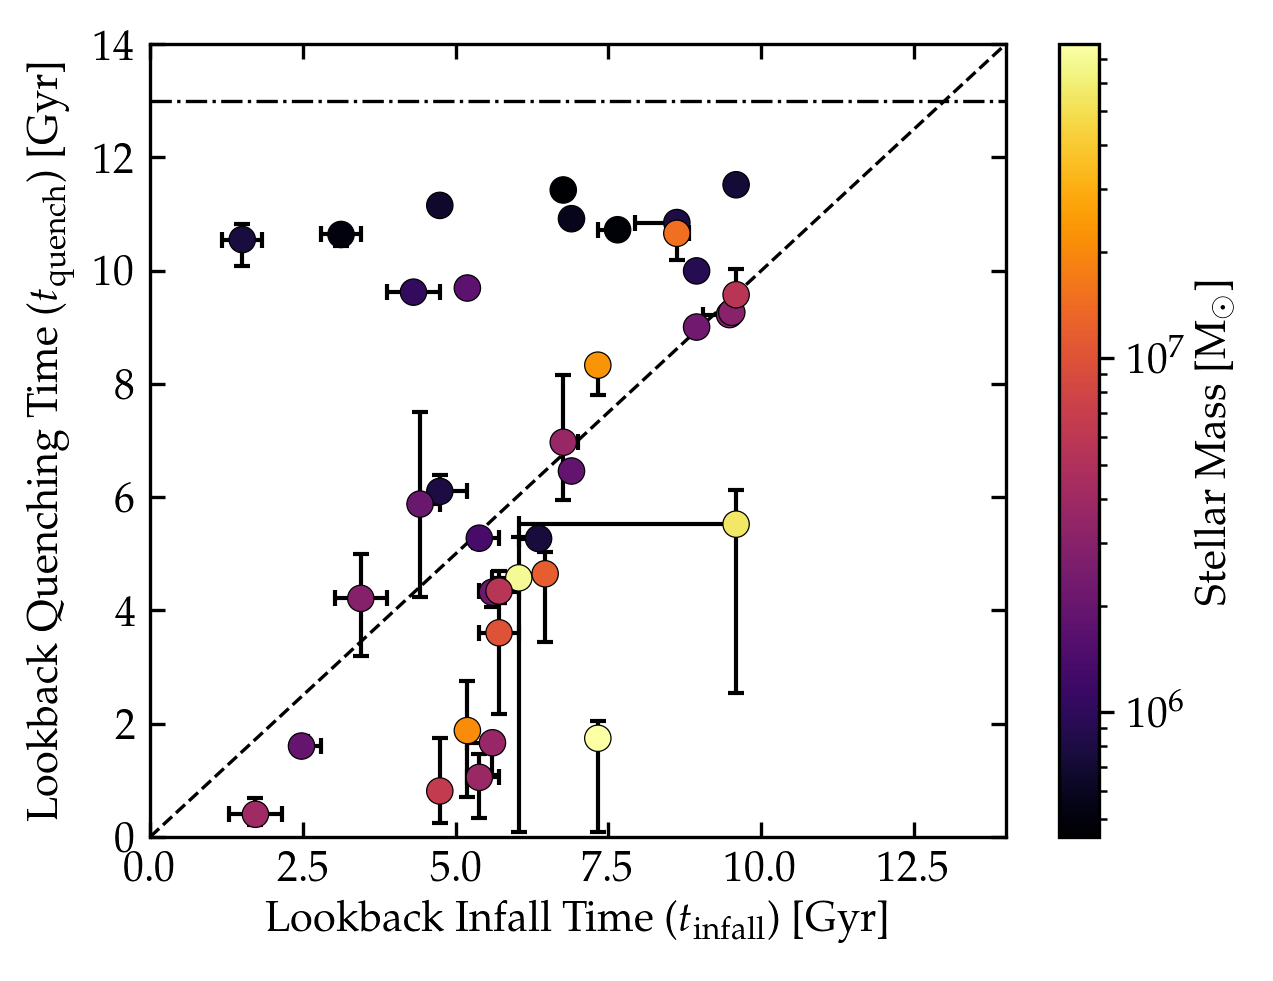

In [11]:
 
reiontime = 13 # in our cosmic UV model reionization occurs at z ~ 6.7 or 13 Gyr ago


fig, ax = plt.subplots(1,1,figsize=(4.6,3.5),dpi=300)

print('Loading...', end='\t')
data = read_data()

data = data[(~np.isnan(np.array(data.tinfall,dtype=float)))&(np.array(data.quenched,dtype=bool))]
data = data[~((data.sim=='h148')&(data.haloid==759))]


tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)
tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)

tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)



Mr = np.array(data.R_mag, dtype=float)
Mr_sol = 4.6
L = 10**((Mr_sol - Mr)/2.5)
mstar = L

# mstar = np.array(data.M_star, dtype=float)



mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')


ax.errorbar(tinfall, tquench,
             xerr = np.array([np.abs(tinfall-tinfall_upper), np.abs(tinfall-tinfall_lower)]),
             yerr = np.array([np.abs(tquench-tquench_upper), np.abs(tquench-tquench_lower)]),
             fmt = 'o',
             elinewidth=1,
             ecolor='k',
             capsize=2,
             capthick=1,
             mfc = 'none',
             mec = 'none',
             ms = 0,
             zorder = 10)

im = ax.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 zorder = 11)

# plot diagonal line
ax.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax.set_xlim(0,14)
ax.set_ylim(0,14)

cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')


ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

# plt.savefig('plots/tq_ti_F19_small.png', dpi=300)
plt.show()

# Quenching time vs. Infall time

Using the 90% quenching threshold

Loading...	loaded data


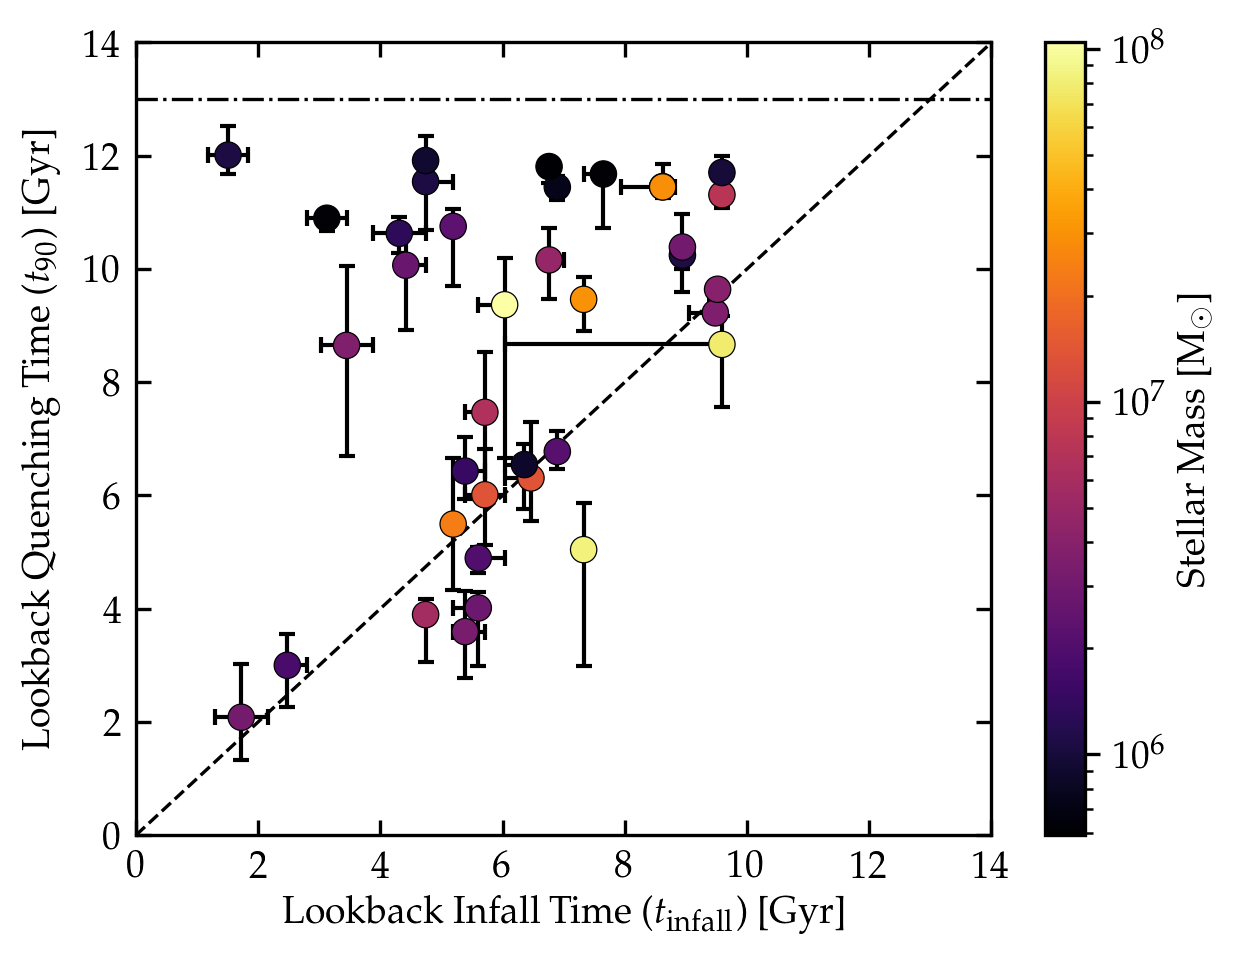

In [62]:
 
reiontime = 13 # in our cosmic UV model reionization occurs at z ~ 6.7 or 13 Gyr ago


fig, ax = plt.subplots(1,1,figsize=(4.6,3.5),dpi=300)

print('Loading...', end='\t')
data = read_data()

data = data[(~np.isnan(np.array(data.tinfall,dtype=float)))&(np.array(data.quenched,dtype=bool))]
data = data[~((data.sim=='h148')&(data.haloid==759))]


tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)
tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)

tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')


ax.errorbar(tinfall, tquench,
             xerr = np.array([np.abs(tinfall-tinfall_upper), np.abs(tinfall-tinfall_lower)]),
             yerr = np.array([np.abs(tquench-tquench_upper), np.abs(tquench-tquench_lower)]),
             fmt = 'o',
             elinewidth=1,
             ecolor='k',
             capsize=2,
             capthick=1,
             mfc = 'none',
             mec = 'none',
             ms = 0,
             zorder = 10)

im = ax.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 zorder = 11)

# plot diagonal line
ax.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax.set_ylabel('Lookback Quenching Time ($t_{\mathrm{90}}$) [Gyr]')
ax.set_xlim(0,14)
ax.set_ylim(0,14)

cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')


ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.savefig('plots/tq_ti_F19_small_90.png', dpi=300)
plt.show()

# for reference

The same plot but with simulation and halo IDs labeled so that we can look into interesting halos as case studies. 

Loading...	loaded data


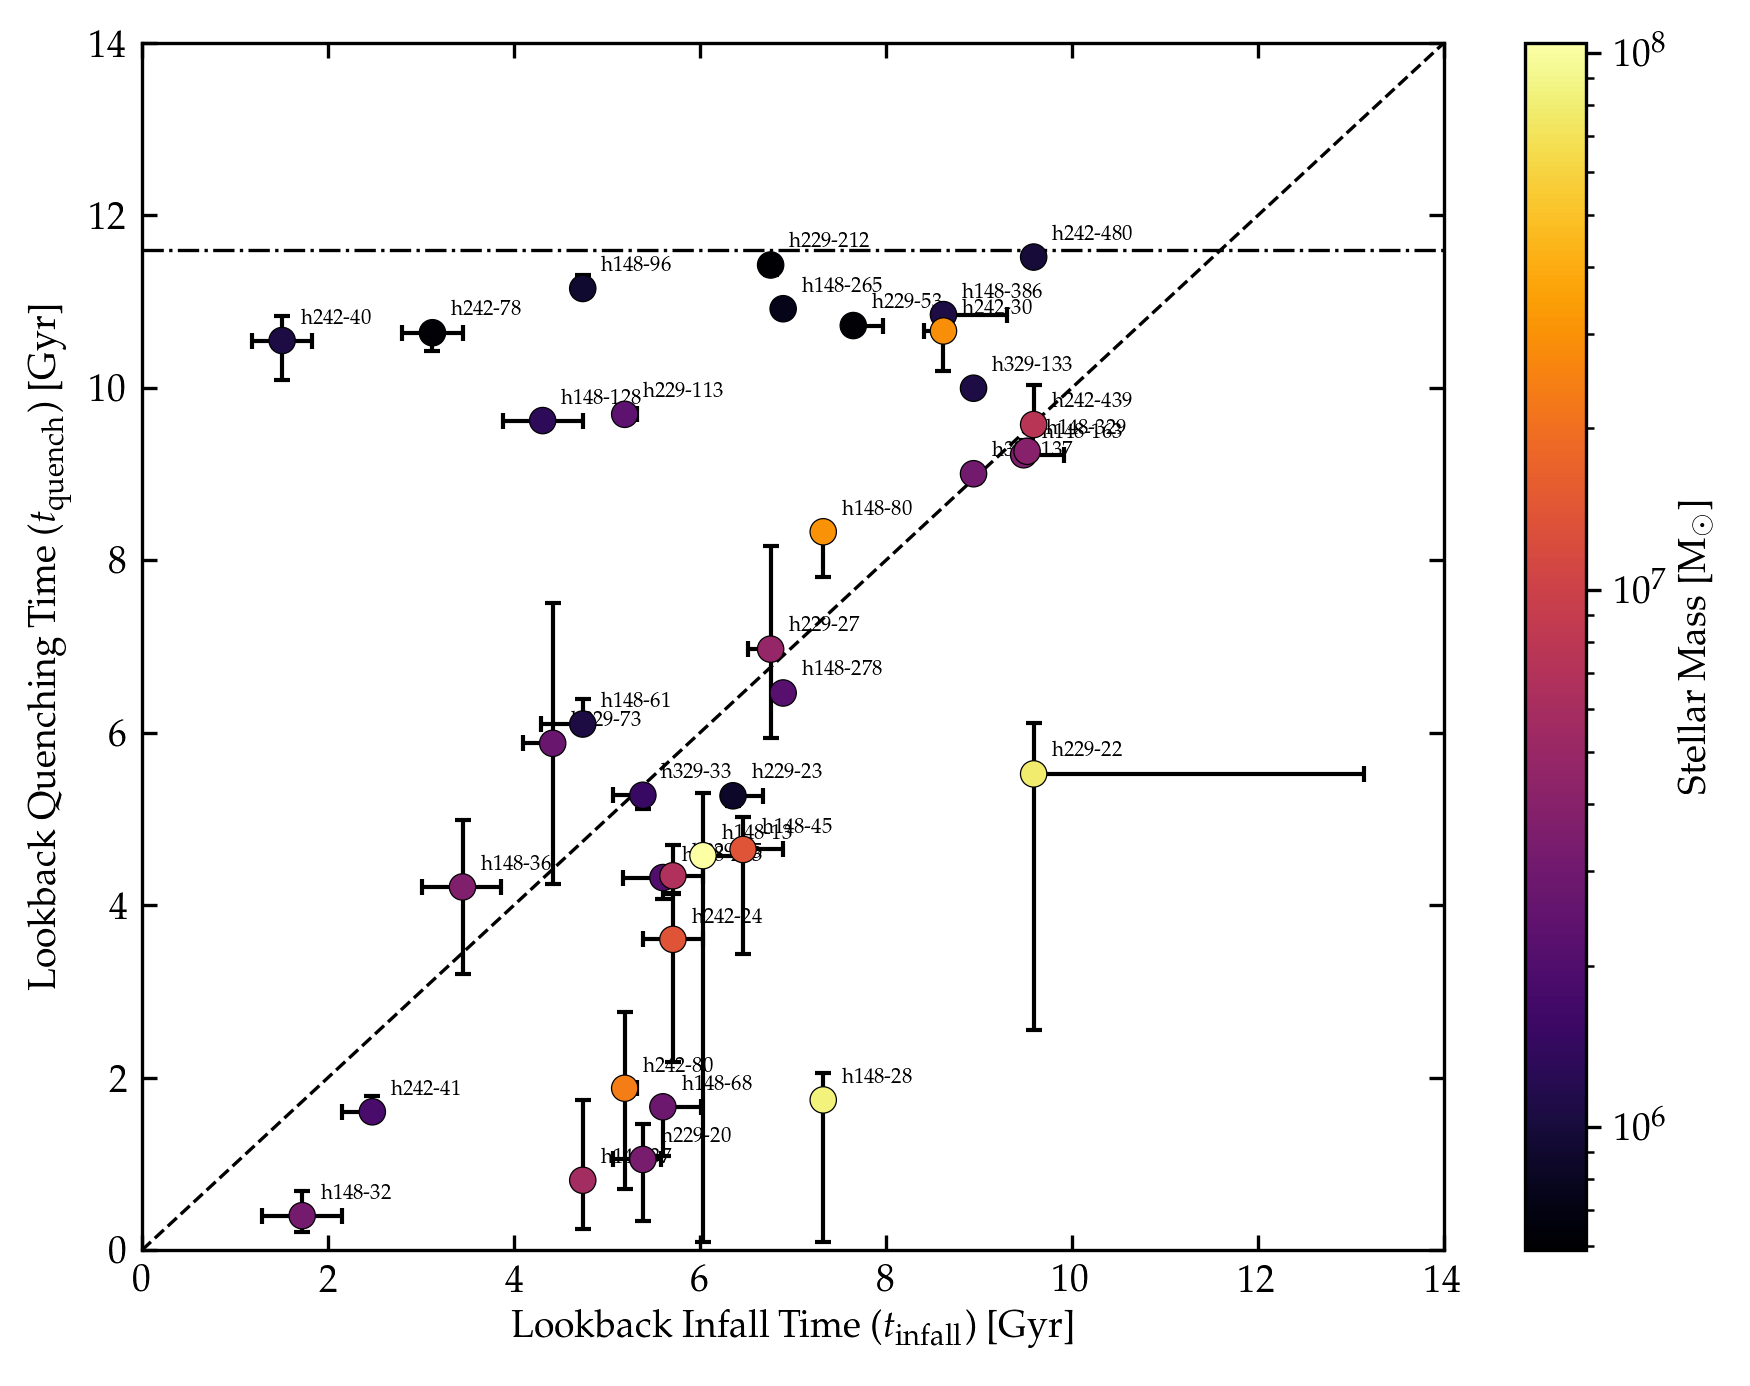

In [38]:
 
reiontime = 11.6 # according to Brown et al (2014), 100% of star formation cuts off by 11.6 Gyr ago in reionization quenching


fig, ax = plt.subplots(1,1,figsize=(7,5.33),dpi=300)

print('Loading...', end='\t')
data = read_data()

data = data[(~np.isnan(np.array(data.tinfall,dtype=float)))&(np.array(data.quenched,dtype=bool))]
data = data[~((data.sim=='h148')&(data.haloid==759))]


tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)
tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)

tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')


ax.errorbar(tinfall, tquench,
             xerr = np.array([np.abs(tinfall-tinfall_lower), np.abs(tinfall-tinfall_upper)]),
             yerr = np.array([np.abs(tquench-tquench_upper),np.abs(tquench-tquench_lower)]),
             fmt = 'o',
             elinewidth=1,
             ecolor='k',
             capsize=2,
             capthick=1,
             mfc = 'none',
             mec = 'none',
             ms = 0,
             zorder = 10)

im = ax.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 zorder = 11)

# plot diagonal line
ax.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax.set_xlim(0,14)
ax.set_ylim(0,14)

for i, (haloid, simulation) in enumerate(zip(newids, sim)):
    if tinfall[i] != None and tquench[i] != None:
        ax.annotate(str(simulation)+'-'+str(int(haloid)), (tinfall[i]+0.2, tquench[i]+0.2), size=5)


cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')


ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

# plt.savefig('QT_IT.png', dpi=300)
plt.show()

In [40]:
data = read_z0file('h148')
data[data.haloid==36]

,B-V,B_mag,G_inflow_0,G_inflow_1.5,G_inflow_2.5,G_outflow_0,G_outflow_1.5,G_outflow_2.5,Gin_T,Gout_T,...,n_star,ovdens,sSFR,sfh,sfhbins,tquench,zgas,zstar,sim,g-r
16,0.731394,-10.34402500980229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,753,199.94,0.0,"[0.00018869488948093917, 0.001069425205947293,...","[0.6735711013691166, 0.7514269999715897, 0.829...",8.650512226319186,nan,0.000495972711768298,h148,0.6795790013914237


<Figure size 432x288 with 0 Axes>

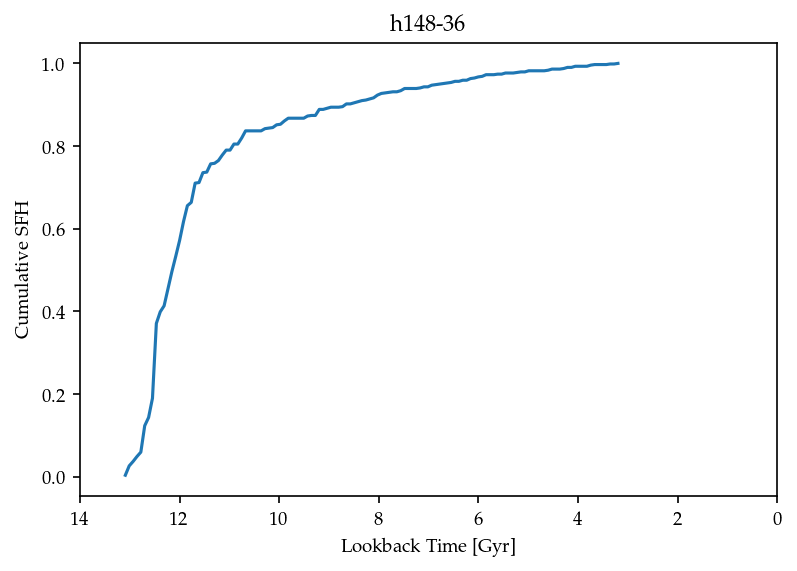

In [43]:
data = read_file('/home/akinshol/Data/Timescales/DataFiles20190731/h148.data',36)

c_sfh, lbt = cumulative_sfh('/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.004096', 36)

plt.figure(dpi=150)
plt.plot(lbt, c_sfh)
plt.xlim(14,0)
plt.ylabel('Cumulative SFH')
plt.xlabel('Lookback Time [Gyr]')
plt.title('h148-36')
plt.show()

<Figure size 432x288 with 0 Axes>

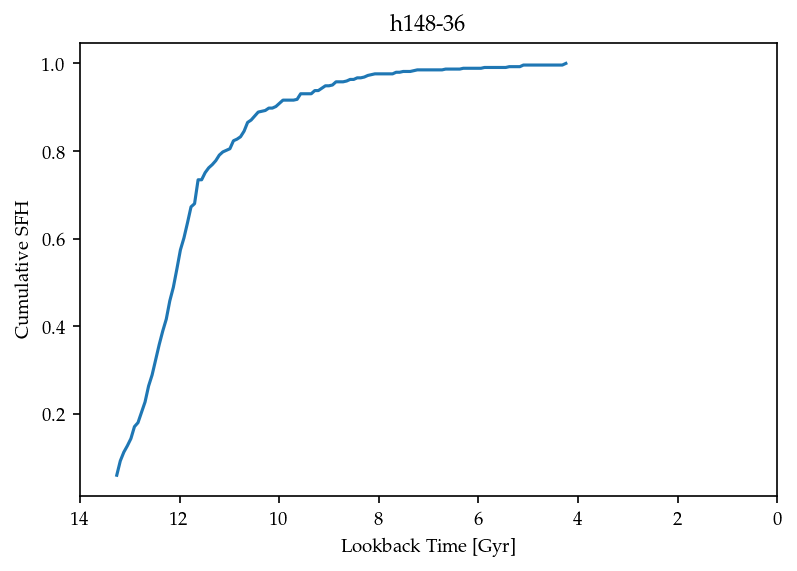

In [45]:
c_sfh, lbt = cumulative_sfh('/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h229.cosmo50PLK.3072gst5HbwK1BH.004096', 73)

plt.figure(dpi=150)
plt.plot(lbt, c_sfh)
plt.xlim(14,0)
plt.ylabel('Cumulative SFH')
plt.xlabel('Lookback Time [Gyr]')
plt.title('h229-73')
plt.show()